# SIH: AI-based Drop-out Prediction and Counseling (Exploration)

This notebook loads and cleans the provided CSVs, explores key relationships, proposes initial rule-based risk thresholds, and optionally fits a tiny decision tree for illustration.


In [4]:
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Local helper
from load_data import read_all_csvs

# Resolve data directory robustly for Jupyter
candidates = []
if '__file__' in globals():
    candidates.append(Path(__file__).parent)
candidates.append(Path.cwd())
candidates.append(Path.cwd() / 'dataset whole')
DATA_DIR = next((p for p in candidates if p.exists() and any(p.glob('*.csv'))), Path.cwd())
print(f"Reading from: {DATA_DIR}")

dfs = read_all_csvs(DATA_DIR)
print(f"Loaded {len(dfs)} CSVs: {sorted(dfs.keys())}")

# Quick head/shape for sanity
for name, df in dfs.items():
    print('='*90)
    print(f"{name}: shape={df.shape}")
    display(df.head(3))


Reading from: d:\Dataset_for_sih\dataset whole
Loaded 22 CSVs: ['BharatiyaVidya_Activities', 'BharatiyaVidya_Admin', 'BharatiyaVidya_Alerts', 'BharatiyaVidya_Assessments', 'BharatiyaVidya_Attendance', 'BharatiyaVidya_Behavioral', 'BharatiyaVidya_Fees', 'BharatiyaVidya_Mentor_Mapping', 'BharatiyaVidya_Mentors', 'BharatiyaVidya_Parents', 'BharatiyaVidya_Students', 'Saraswati_Activities', 'Saraswati_Admin', 'Saraswati_Alerts', 'Saraswati_Assessments', 'Saraswati_Attendance', 'Saraswati_Behavioral', 'Saraswati_Fees', 'Saraswati_Mentor_Mapping', 'Saraswati_Mentors', 'Saraswati_Parents', 'Saraswati_Students']
BharatiyaVidya_Activities: shape=(2459, 9)


,activity_id,student_id,activity_name,participation_level,start_date,performance_rating,achievements,attendance_percentage,instructor
0,ACT_INST_001_000001,STU_INST_001_0001,Music,Beginner,2025-07-22,Needs Improvement,NaN,72,Maya Nair
1,ACT_INST_001_000002,STU_INST_001_0002,Athletics,Advanced,2025-07-12,Very Good,NaN,100,Rahul Arora
2,ACT_INST_001_000003,STU_INST_001_0002,Dance,Intermediate,2025-03-20,Needs Improvement,NaN,97,Karan Jadhav


BharatiyaVidya_Admin: shape=(1, 10)


,admin_id,institute_id,institute_name,admin_name,email,phone,city,total_students,total_mentors,created_date
0,ADM_INST_001_001,INST_001,Bharatiya Vidya Mandir,Dr. Vihaan Reddy,principalinstituteinst_001@yahoo.com,+91-9581960013,Chennai,2000,24,2025-09-16 07:41:56


BharatiyaVidya_Alerts: shape=(3153, 14)


,alert_id,student_id,alert_type,priority,message,created_date,status,assigned_to,escalated,parent_notified,sms_sent,email_sent,action_required,follow_up_date
0,ALT_INST_001_000001,STU_INST_001_0001,Fee Defaulter,Medium,Fee Defaulter flagged for student Arjun Iyer -...,2025-09-12 07:43:16,Active,MEN_INST_001_001,False,True,True,True,True,2025-09-25
1,ALT_INST_001_000002,STU_INST_001_0001,Behavioral Issues,Medium,Behavioral Issues flagged for student Arjun Iy...,2025-08-18 07:43:16,Acknowledged,MEN_INST_001_001,False,True,True,True,False,NaN
2,ALT_INST_001_000003,STU_INST_001_0003,Academic Decline,Medium,Academic Decline flagged for student Riya Bhat...,2025-09-08 07:43:16,Active,MEN_INST_001_003,False,False,True,True,True,2025-09-24


BharatiyaVidya_Assessments: shape=(30071, 11)


,assessment_id,student_id,subject,assessment_type,date,max_marks,obtained_marks,percentage,grade,term,remarks
0,ASS_INST_001_000001,STU_INST_001_0001,Mathematics,Project Work,2025-08-31,50,32,65.6,B2,Final Term,Good
1,ASS_INST_001_000002,STU_INST_001_0001,Social Studies,Half Yearly Exam,2025-06-29,50,15,31.1,D,First Term,Needs Improvement
2,ASS_INST_001_000003,STU_INST_001_0001,Biology,Final Exam,2025-09-08,80,27,33.8,D,Final Term,Needs Improvement


BharatiyaVidya_Attendance: shape=(40000, 12)


,attendance_id,student_id,date,status,period_1,period_2,period_3,period_4,period_5,period_6,period_7,remarks
0,ATT_INST_001_000001,STU_INST_001_0001,2025-08-18,Present,True,True,True,True,True,True,True,NaN
1,ATT_INST_001_000002,STU_INST_001_0001,2025-08-19,Present,True,True,True,True,True,True,True,NaN
2,ATT_INST_001_000003,STU_INST_001_0001,2025-08-20,Present,True,True,True,True,True,True,True,NaN


BharatiyaVidya_Behavioral: shape=(2326, 12)


,incident_id,student_id,date,incident_type,severity,description,reported_by,action_taken,parent_informed,follow_up_required,resolved,counselor_involved
0,BEH_INST_001_000001,STU_INST_001_0001,2025-03-19,Verbal Abuse,Moderate,Student involved in verbal abuse during class ...,Principal Nidhi Joshi,Verbal Warning,True,True,True,True
1,BEH_INST_001_000002,STU_INST_001_0001,2025-03-19,Bullying,Minor,Student involved in bullying during assembly,Class Teacher Laksh Raman,Behavior Contract,False,False,False,True
2,BEH_INST_001_000003,STU_INST_001_0002,2025-07-10,Bunking Classes,Minor,Student involved in bunking classes during spo...,Class Teacher Seema More,After School Detention,True,True,False,False


BharatiyaVidya_Fees: shape=(11042, 13)


,fee_id,student_id,fee_type,academic_year,quarter,due_date,amount_due,amount_paid,balance,payment_status,last_payment_date,payment_method,late_fee
0,FEE_INST_001_000001,STU_INST_001_0001,Tuition Fee,2024-25,Q3,2025-09-30,27131,27131,0,Paid,2025-06-27,UPI,0
1,FEE_INST_001_000002,STU_INST_001_0001,Activity Fee,2024-25,Q1,2025-11-17,4585,4585,0,Paid,2025-08-28,Online Banking,0
2,FEE_INST_001_000003,STU_INST_001_0001,Exam Fee,2024-25,Q1,2025-08-24,6461,6461,0,Paid,2025-07-28,Card Payment,0


BharatiyaVidya_Mentor_Mapping: shape=(2000, 12)


,mapping_id,mentor_id,student_id,assigned_date,status,last_interaction,interaction_type,interaction_frequency,communication_mode,parent_contact_frequency,academic_support_provided,counseling_sessions
0,MAP_INST_001_000001,MEN_INST_001_001,STU_INST_001_0001,2024-11-11,Active,2025-08-26,Parent Meeting,Weekly,In Person,Monthly,True,0
1,MAP_INST_001_000002,MEN_INST_001_002,STU_INST_001_0002,2023-10-23,Active,2025-09-14,Academic Review,Monthly,Email,Fortnightly,True,1
2,MAP_INST_001_000003,MEN_INST_001_003,STU_INST_001_0003,2025-06-16,Active,2025-09-04,Progress Update,Bi-weekly,SMS,Monthly,False,1


BharatiyaVidya_Mentors: shape=(24, 10)


,mentor_id,institute_id,name,gender,email,phone,department,experience_years,qualification,assigned_students
0,MEN_INST_001_001,INST_001,Sanjay Mondal,Male,sanjay28@yahoo.com,+91-8163794026,Computer Science,9,M.Ed,85
1,MEN_INST_001_002,INST_001,Samar Raman,Male,samar.raman@rediffmail.com,+91-9555940781,Physics,3,Ph.D,85
2,MEN_INST_001_003,INST_001,Kriti Kar,Female,kriti_kar@hotmail.com,+91-9210341316,Social Studies,15,M.A.,85


BharatiyaVidya_Parents: shape=(1700, 15)


,parent_id,institute_id,father_name,mother_name,primary_contact,email,phone_primary,phone_secondary,address,occupation_father,occupation_mother,income_bracket,children_count,religion,caste_category
0,PAR_INST_001_0001,INST_001,Rajesh Iyer,Shreya Iyer,Rajesh Iyer,rajeshiyer@rediffmail.com,+91-8841458685,+91-9814294019,"Villa No. 354, Enclave 28, Chennai",Bank Manager,Software Developer,< 2 LPA,1,Sikh,OBC
1,PAR_INST_001_0002,INST_001,Aryan Agarwal,Riya Agarwal,Aryan Agarwal,aryan2@hotmail.com,+91-9256159514,+91-8246564823,"Villa No. 681, Extension 44, Chennai",Police Officer,Nurse,15-25 LPA,1,Buddhist,SC
2,PAR_INST_001_0003,INST_001,Ankit Bhattacharya,Aadhya Bhattacharya,Ankit Bhattacharya,ankitbhattacharya@rediffmail.com,+91-8095777387,+91-9314895134,"Flat No. 826, Nagar 10, Chennai",Engineer,Homemaker,2-5 LPA,1,Sikh,General


BharatiyaVidya_Students: shape=(2000, 21)


,student_id,institute_id,parent_id,mentor_id,name,gender,grade,section,roll_number,date_of_birth,...,academic_year,attendance_percentage,current_gpa,behavioral_incidents,risk_level,last_assessment_score,fees_paid,transport_mode,medium_of_instruction,special_needs
0,STU_INST_001_0001,INST_001,PAR_INST_001_0001,MEN_INST_001_001,Arjun Iyer,Male,12th,D,108312,2011-05-16,...,2025-26,89.5,2.72,2,Medium,89,Yes,Auto Rickshaw,Regional Language,NaN
1,STU_INST_001_0002,INST_001,PAR_INST_001_0002,MEN_INST_001_002,Manoj Agarwal,Male,9th,C,105447,2008-01-25,...,2025-26,86.2,3.41,1,Low,84,No,Private Vehicle,English,NaN
2,STU_INST_001_0003,INST_001,PAR_INST_001_0003,MEN_INST_001_003,Riya Bhattacharya,Female,11th,C,113896,2010-02-23,...,2025-26,73.3,2.48,0,Medium,44,Partial,Walking,Regional Language,NaN


Saraswati_Activities: shape=(2441, 9)


,activity_id,student_id,activity_name,participation_level,start_date,performance_rating,achievements,attendance_percentage,instructor
0,ACT_INST_002_000001,STU_INST_002_0002,Environmental Club,Beginner,2025-07-20,Good,State Level Qualifier,90,Myra Menon
1,ACT_INST_002_000002,STU_INST_002_0002,Football,Advanced,2025-05-01,Average,NaN,70,Seema Jindal
2,ACT_INST_002_000003,STU_INST_002_0002,Art & Craft,Intermediate,2024-12-26,Good,NaN,99,Maya Bhatt


Saraswati_Admin: shape=(1, 10)


,admin_id,institute_id,institute_name,admin_name,email,phone,city,total_students,total_mentors,created_date
0,ADM_INST_002_001,INST_002,Saraswati International School,Dr. Deepika Verma,principal851@hotmail.com,+91-8721772962,Jaipur,2000,24,2025-09-16 07:41:56


Saraswati_Alerts: shape=(3141, 14)


,alert_id,student_id,alert_type,priority,message,created_date,status,assigned_to,escalated,parent_notified,sms_sent,email_sent,action_required,follow_up_date
0,ALT_INST_002_000001,STU_INST_002_0001,Uniform Violations,Medium,Uniform Violations flagged for student Rajesh ...,2025-09-05 07:43:16,In Progress,MEN_INST_002_001,False,True,False,False,True,NaN
1,ALT_INST_002_000002,STU_INST_002_0001,Parent Meeting Required,Medium,Parent Meeting Required flagged for student Ra...,2025-09-01 07:43:16,Resolved,MEN_INST_002_001,False,True,False,True,False,2025-09-27
2,ALT_INST_002_000003,STU_INST_002_0001,Academic Decline,Medium,Academic Decline flagged for student Rajesh Da...,2025-09-05 07:43:16,Acknowledged,MEN_INST_002_001,False,True,False,False,True,NaN


Saraswati_Assessments: shape=(29959, 11)


,assessment_id,student_id,subject,assessment_type,date,max_marks,obtained_marks,percentage,grade,term,remarks
0,ASS_INST_002_000001,STU_INST_002_0001,Hindi,Viva Voce,2025-05-27,50,15,30.0,D,Second Term,Needs Improvement
1,ASS_INST_002_000002,STU_INST_002_0001,Science,Quiz,2025-07-22,20,16,80.3,A2,Final Term,Excellent
2,ASS_INST_002_000003,STU_INST_002_0001,Science,Viva Voce,2025-05-19,25,12,51.3,C1,Final Term,Satisfactory


Saraswati_Attendance: shape=(40000, 12)


,attendance_id,student_id,date,status,period_1,period_2,period_3,period_4,period_5,period_6,period_7,remarks
0,ATT_INST_002_000001,STU_INST_002_0001,2025-08-18,Present,True,True,True,True,True,True,True,NaN
1,ATT_INST_002_000002,STU_INST_002_0001,2025-08-19,Present,True,True,True,True,True,False,True,NaN
2,ATT_INST_002_000003,STU_INST_002_0001,2025-08-20,Excused,False,False,False,False,False,False,False,No Reason Given


Saraswati_Behavioral: shape=(2435, 12)


,incident_id,student_id,date,incident_type,severity,description,reported_by,action_taken,parent_informed,follow_up_required,resolved,counselor_involved
0,BEH_INST_002_000001,STU_INST_002_0001,2025-08-02,Bullying,Major,Student involved in bullying during class hours,Discipline Incharge Vihaan Patel,Written Warning,True,True,False,True
1,BEH_INST_002_000002,STU_INST_002_0002,2025-03-15,Classroom Disruption,Major,Student involved in classroom disruption durin...,Principal Aryan Bhardwaj,Behavior Contract,True,False,False,False
2,BEH_INST_002_000003,STU_INST_002_0003,2025-04-04,Damage to Property,Moderate,Student involved in damage to property during ...,Subject Teacher Advait Dave,Apology Letter,False,True,True,False


Saraswati_Fees: shape=(11004, 13)


,fee_id,student_id,fee_type,academic_year,quarter,due_date,amount_due,amount_paid,balance,payment_status,last_payment_date,payment_method,late_fee
0,FEE_INST_002_000001,STU_INST_002_0001,Activity Fee,2024-25,Q1,2025-09-21,5642,2821,2821,Partial,2025-08-30,DD,0
1,FEE_INST_002_000002,STU_INST_002_0001,Library Fee,2024-25,Q2,2025-09-26,5820,2910,2910,Partial,2025-09-14,Card Payment,445
2,FEE_INST_002_000003,STU_INST_002_0001,Development Fee,2024-25,Q4,2025-10-25,4971,2485,2486,Partial,2025-08-08,Cheque,0


Saraswati_Mentor_Mapping: shape=(2000, 12)


,mapping_id,mentor_id,student_id,assigned_date,status,last_interaction,interaction_type,interaction_frequency,communication_mode,parent_contact_frequency,academic_support_provided,counseling_sessions
0,MAP_INST_002_000001,MEN_INST_002_001,STU_INST_002_0001,2025-05-30,Active,2025-09-04,Behavioral Discussion,Bi-weekly,SMS,Monthly,True,5
1,MAP_INST_002_000002,MEN_INST_002_002,STU_INST_002_0002,2025-06-16,Active,2025-08-30,Behavioral Discussion,Monthly,In Person,Monthly,True,3
2,MAP_INST_002_000003,MEN_INST_002_003,STU_INST_002_0003,2023-10-12,Active,2025-08-29,Counseling Session,Weekly,In Person,Weekly,True,0


Saraswati_Mentors: shape=(24, 10)


,mentor_id,institute_id,name,gender,email,phone,department,experience_years,qualification,assigned_students
0,MEN_INST_002_001,INST_002,Dev Tiwari,Male,dev_tiwari@yahoo.co.in,+91-8571844617,Hindi,5,M.Sc.,85
1,MEN_INST_002_002,INST_002,Preeti Kumar,Female,pkumar@rediffmail.com,+91-8674001847,Economics,21,M.Sc.,85
2,MEN_INST_002_003,INST_002,Isha Mandal,Female,isha_mandal@yahoo.com,+91-8796071240,Biology,9,M.Sc.,85


Saraswati_Parents: shape=(1700, 15)


,parent_id,institute_id,father_name,mother_name,primary_contact,email,phone_primary,phone_secondary,address,occupation_father,occupation_mother,income_bracket,children_count,religion,caste_category
0,PAR_INST_002_0001,INST_002,Raj Dave,Riya Dave,Raj Dave,rajdave@rediffmail.com,+91-9808438006,+91-9199378236,"House No. 14, Market 43, Jaipur",Accountant,Lawyer,2-5 LPA,1,Hindu,General
1,PAR_INST_002_0002,INST_002,Nitin Dubey,Myra Dubey,Nitin Dubey,nitin705@gmail.com,+91-8551680047,+91-9315357009,"Flat No. 339, Market 6, Jaipur",Lawyer,Homemaker,2-5 LPA,1,Hindu,General
2,PAR_INST_002_0003,INST_002,Dhruv Subramanian,Neha Subramanian,Dhruv Subramanian,dhruv.subramanian@yahoo.co.in,+91-9587890052,+91-8094232554,"Flat No. 662, Nagar 17, Jaipur",Bank Manager,Nurse,25+ LPA,1,Muslim,OBC


Saraswati_Students: shape=(2000, 21)


,student_id,institute_id,parent_id,mentor_id,name,gender,grade,section,roll_number,date_of_birth,...,academic_year,attendance_percentage,current_gpa,behavioral_incidents,risk_level,last_assessment_score,fees_paid,transport_mode,medium_of_instruction,special_needs
0,STU_INST_002_0001,INST_002,PAR_INST_002_0001,MEN_INST_002_001,Rajesh Dave,Male,9th,B,9t9874,2010-06-08,...,2025-26,77.2,2.58,1,Medium,72,Partial,Bicycle,Hindi,NaN
1,STU_INST_002_0002,INST_002,PAR_INST_002_0002,MEN_INST_002_002,Sana Dubey,Female,9th,B,9t7182,2008-06-06,...,2025-26,96.2,2.62,1,Low,54,No,Walking,Hindi,NaN
2,STU_INST_002_0003,INST_002,PAR_INST_002_0003,MEN_INST_002_003,Aarav Subramanian,Male,9th,E,117235,2007-11-02,...,2025-26,80.6,3.84,5,Medium,63,Partial,Walking,Hindi,NaN


In [5]:
# Basic cleaning helpers

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip().replace('\n', ' ').replace('\r', ' ').strip() for c in df.columns]
    return df


def to_numeric_safe(series: pd.Series):
    return pd.to_numeric(series, errors='coerce')


def parse_date_safe(series: pd.Series):
    return pd.to_datetime(series, errors='coerce')


# Apply basic normalization to all
for name in list(dfs.keys()):
    dfs[name] = normalize_columns(dfs[name])

# Identify key tables by name heuristics without using boolean or on DataFrames

def pick_table(preferred_names):
    for n in preferred_names:
        if n in dfs:
            return dfs[n]
    return None

students = pick_table(['BharatiyaVidya_Students','Saraswati_Students','Students'])
assessments = pick_table(['BharatiyaVidya_Assessments','Saraswati_Assessments','Assessments'])
attendance = pick_table(['BharatiyaVidya_Attendance','Saraswati_Attendance','Attendance'])
fees = pick_table(['BharatiyaVidya_Fees','Saraswati_Fees','Fees'])

print('Tables found:', {
    'students': students is not None,
    'assessments': assessments is not None,
    'attendance': attendance is not None,
    'fees': fees is not None,
})

# Harmonize student_id key if present
key_cols = ['student_id', 'Student_ID', 'StudentId']

def pick_key(df):
    if df is None:
        return None
    for k in key_cols:
        if k in df.columns:
            return k
    return None

sid_students = pick_key(students)
sid_assess = pick_key(assessments)
sid_att = pick_key(attendance)
sid_fee = pick_key(fees)

# Coerce types for numeric fields used later if present
if students is not None:
    for col in ['attendance_percentage', 'current_gpa', 'behavioral_incidents', 'last_assessment_score']:
        if col in students.columns:
            students[col] = to_numeric_safe(students[col])

if assessments is not None:
    for col in ['max_marks', 'obtained_marks', 'percentage']:
        if col in assessments.columns:
            assessments[col] = to_numeric_safe(assessments[col])
    for col in ['date']:
        if col in assessments.columns:
            assessments[col] = parse_date_safe(assessments[col])

if attendance is not None:
    for col in ['date']:
        if col in attendance.columns:
            attendance[col] = parse_date_safe(attendance[col])

if fees is not None:
    for col in ['amount_due', 'amount_paid', 'balance']:
        if col in fees.columns:
            fees[col] = to_numeric_safe(fees[col])
    for col in ['due_date', 'last_payment_date']:
        if col in fees.columns:
            fees[col] = parse_date_safe(fees[col])

# Build consolidated features per student (basic)
consol = None
if students is not None:
    consol = students.copy()
    # Rename for clarity if expected columns exist
    rename_map = {
        'attendance_percentage': 'attend_pct',
        'current_gpa': 'gpa',
        'behavioral_incidents': 'beh_incidents',
        'last_assessment_score': 'last_score'
    }
    for k, v in rename_map.items():
        if k in consol.columns:
            consol.rename(columns={k: v}, inplace=True)

# Aggregate assessments: mean percentage per student
if consol is not None and assessments is not None and sid_assess is not None:
    assess_agg = (
        assessments.groupby(sid_assess)['percentage']
        .mean()
        .rename('mean_score')
        .reset_index()
    )
    consol = consol.merge(assess_agg, left_on=sid_students, right_on=sid_assess, how='left')

# Aggregate attendance: present rate if status column exists
if consol is not None and attendance is not None and sid_att is not None:
    if 'status' in attendance.columns:
        att_map = attendance.assign(
            present=lambda d: (d['status'].astype(str).str.lower() == 'present').astype(int)
        ).groupby(sid_att)['present'].mean().rename('att_rate').reset_index()
        consol = consol.merge(att_map, left_on=sid_students, right_on=sid_att, how='left')

# Aggregate fees: total balance per student
if consol is not None and fees is not None and sid_fee is not None:
    if 'balance' in fees.columns:
        fee_agg = fees.groupby(sid_fee)['balance'].sum().rename('fee_balance').reset_index()
        consol = consol.merge(fee_agg, left_on=sid_students, right_on=sid_fee, how='left')

print('Consolidated shape:', None if consol is None else consol.shape)
if consol is not None:
    display(consol.head(5))


Tables found: {'students': True, 'assessments': True, 'attendance': True, 'fees': True}
Consolidated shape: (2000, 24)


,student_id,institute_id,parent_id,mentor_id,name,gender,grade,section,roll_number,date_of_birth,...,beh_incidents,risk_level,last_score,fees_paid,transport_mode,medium_of_instruction,special_needs,mean_score,att_rate,fee_balance
0,STU_INST_001_0001,INST_001,PAR_INST_001_0001,MEN_INST_001_001,Arjun Iyer,Male,12th,D,108312,2011-05-16,...,2,Medium,89,Yes,Auto Rickshaw,Regional Language,NaN,54.657143,0.85,0
1,STU_INST_001_0002,INST_001,PAR_INST_001_0002,MEN_INST_001_002,Manoj Agarwal,Male,9th,C,105447,2008-01-25,...,1,Low,84,No,Private Vehicle,English,NaN,62.172222,0.90,51417
2,STU_INST_001_0003,INST_001,PAR_INST_001_0003,MEN_INST_001_003,Riya Bhattacharya,Female,11th,C,113896,2010-02-23,...,0,Medium,44,Partial,Walking,Regional Language,NaN,46.492857,0.75,13431
3,STU_INST_001_0004,INST_001,PAR_INST_001_0004,MEN_INST_001_004,Sara Deshpande,Female,12th,E,9t9836,2007-09-23,...,1,Medium,60,Yes,Walking,Regional Language,NaN,29.571429,0.80,0
4,STU_INST_001_0005,INST_001,PAR_INST_001_0005,MEN_INST_001_005,Amit Das,Male,12th,A,9t6751,2009-03-22,...,0,Medium,64,Yes,Bicycle,Regional Language,NaN,46.780000,0.60,0


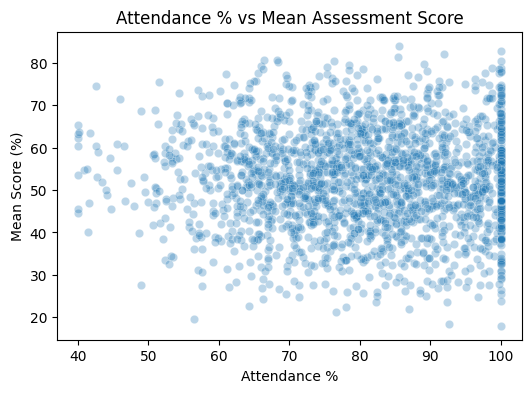

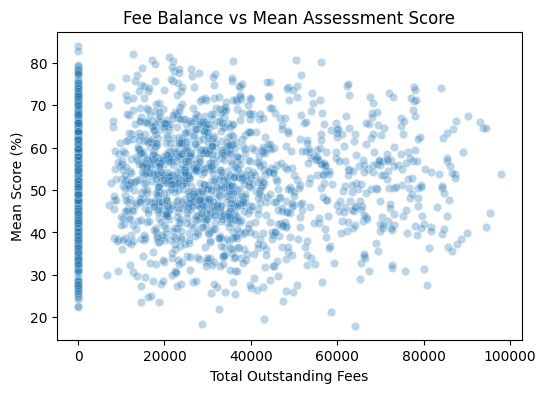

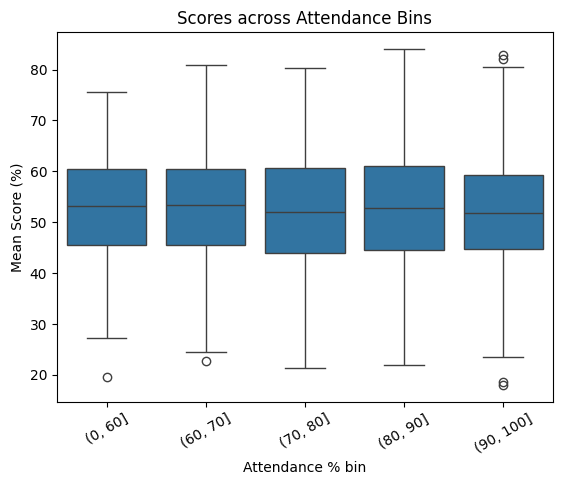

In [6]:
# Quick graphs
if consol is not None:
    plt.figure(figsize=(6,4))
    if 'attend_pct' in consol.columns and 'mean_score' in consol.columns:
        sns.scatterplot(data=consol, x='attend_pct', y='mean_score', alpha=0.3)
        plt.title('Attendance % vs Mean Assessment Score')
        plt.xlabel('Attendance %')
        plt.ylabel('Mean Score (%)')
        plt.show()

    plt.figure(figsize=(6,4))
    if 'fee_balance' in consol.columns and 'mean_score' in consol.columns:
        sns.scatterplot(data=consol, x='fee_balance', y='mean_score', alpha=0.3)
        plt.title('Fee Balance vs Mean Assessment Score')
        plt.xlabel('Total Outstanding Fees')
        plt.ylabel('Mean Score (%)')
        plt.show()

    # Failures proxy: score < 40
    if 'mean_score' in consol.columns:
        consol['fail_flag'] = (consol['mean_score'] < 40).astype(int)
        if 'attend_pct' in consol.columns:
            sns.boxplot(data=consol.assign(bin_att=pd.cut(consol['attend_pct'], bins=[0,60,70,80,90,100])),
                        x='bin_att', y='mean_score')
            plt.title('Scores across Attendance Bins')
            plt.xlabel('Attendance % bin')
            plt.ylabel('Mean Score (%)')
            plt.xticks(rotation=30)
            plt.show()


In [7]:
# Rule-based risk thresholds (initial suggestion)

if consol is not None:
    # Fill required columns if missing
    if 'att_rate' not in consol.columns and 'attend_pct' in consol.columns:
        consol['att_rate'] = consol['attend_pct'] / 100.0

    # Cutoffs (tune as needed with domain input)
    ATT_LOW = 0.75   # <75% attendance
    SCORE_LOW = 50.0 # <50% mean score
    FEES_HIGH = 10000 # INR outstanding > 10k
    BEHAV_HIGH = 3   # >3 incidents

    # Flags
    consol['flag_attendance'] = (consol['att_rate'] < ATT_LOW).fillna(False)
    consol['flag_scores'] = (consol['mean_score'] < SCORE_LOW).fillna(False)
    if 'fee_balance' in consol.columns:
        consol['flag_fees'] = (consol['fee_balance'] > FEES_HIGH).fillna(False)
    else:
        consol['flag_fees'] = False
    if 'beh_incidents' in consol.columns:
        consol['flag_behavior'] = (consol['beh_incidents'] > BEHAV_HIGH).fillna(False)
    else:
        consol['flag_behavior'] = False

    # Combined risk tiers
    consol['risk_points'] = (
        consol[['flag_attendance','flag_scores','flag_fees','flag_behavior']].astype(int).sum(axis=1)
    )
    consol['risk_level_rule'] = pd.cut(
        consol['risk_points'], bins=[-1,0,1,2,4], labels=['Low','Guarded','Medium','High']
    )

    display(consol[['risk_points','risk_level_rule','att_rate','mean_score','fee_balance']].head(10))


,risk_points,risk_level_rule,att_rate,mean_score,fee_balance
0,0,Low,0.85,54.657143,0
1,1,Guarded,0.90,62.172222,51417
2,2,Medium,0.75,46.492857,13431
3,1,Guarded,0.80,29.571429,0
4,2,Medium,0.60,46.780000,0
5,2,Medium,0.70,27.488235,0
6,2,Medium,1.00,47.112500,43602
7,2,Medium,0.65,56.172222,17194
8,0,Low,0.75,58.500000,9466
9,1,Guarded,0.95,71.894118,67649


DecisionTree accuracy: 0.992


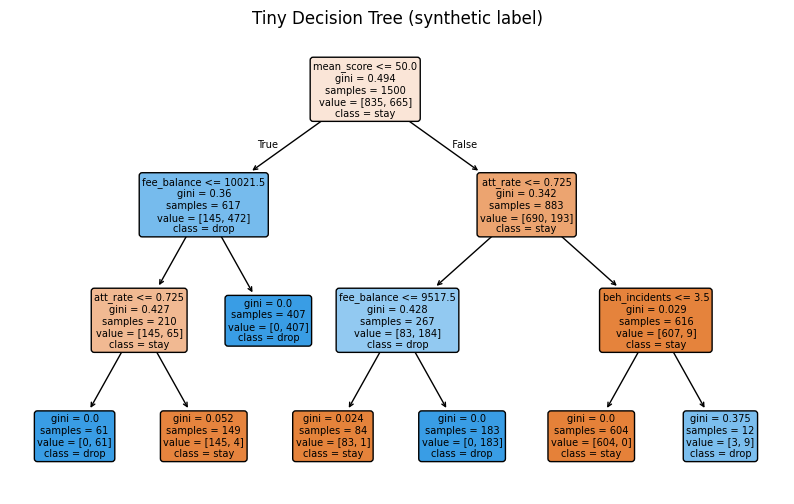

In [8]:
# (Optional) Tiny decision tree on synthetic label
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

if consol is not None:
    work = consol.copy()
    # Create synthetic dropout label using the rule flags
    if {'flag_attendance','flag_scores','flag_fees','flag_behavior'}.issubset(work.columns):
        work['dropout_label'] = (work[['flag_attendance','flag_scores','flag_fees','flag_behavior']].sum(axis=1) >= 2).astype(int)
        features = []
        for col in ['att_rate','mean_score','fee_balance','beh_incidents','gpa','last_score']:
            if col in work.columns:
                features.append(col)
        work = work.dropna(subset=features)
        X = work[features]
        y = work['dropout_label']
        if len(work) > 50 and y.nunique() == 2:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
            clf = DecisionTreeClassifier(max_depth=3, random_state=42)
            clf.fit(X_train, y_train)
            print('DecisionTree accuracy:', clf.score(X_test, y_test))
            plt.figure(figsize=(10,6))
            plot_tree(clf, feature_names=features, class_names=['stay','drop'], filled=True, rounded=True)
            plt.title('Tiny Decision Tree (synthetic label)')
            plt.show()
